In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format='svg'#输出矢量图设置

"""
latitude: 纬度
longitude: 经度
"""

class RoadSection:
    def __init__(self, lat: float, log: float, ang: float, index: int):
        """
        初始化一个路段

        :param lat: 纬度
        :param log: 经度
        :param ang: 角度
        :param index: 在原数据集中的位置
        """
        self.lat = [lat]    # 维度集合
        self.log = [log]    # 经度集合
        self.ang = [ang]    # 角度集合
        self.direction = sum(self.ang) / len(self.ang)  #平均朝向
        self.MostWest = min(self.log)   # 最西端
        self.MostEast = max(self.log)   # 最东端
        self.MostNorth = max(self.lat)  # 最北端
        self.MostSouth = min(self.lat)  # 最南端
        self.DataNum = len(self.lat)    # 点数
        self.index = [index]    # 点在原数据集中的位置

    def add(self, lat: float, log: float, ang: float, index: int):
        self.lat.append(lat)
        self.log.append(log)
        self.index.append(index)
        self.ang.append(ang)
        self.DataNum += 1
        self.MostWest = min(self.log)
        self.MostEast = max(self.log)
        self.MostNorth = max(self.lat)
        self.MostSouth = min(self.lat)
        self.DataNum = len(self.lat)
        self.direction = sum(self.ang) / len(self.ang)

    def merge(self, rs):
        self.lat += rs.lat
        self.log += rs.log
        self.index += rs.index
        self.ang += rs.ang
        self.DataNum += rs.DataNum
        self.MostWest = min(self.log)
        self.MostEast = max(self.log)
        self.MostNorth = max(self.lat)
        self.MostSouth = min(self.lat)
        self.direction = sum(self.ang) / len(self.ang)

data = pd.read_csv('2021-04-29.csv')

LAT = np.array(data.iloc[:, 3])
LOG = np.array(data.iloc[:, 4])
ATI = np.array(data.iloc[:, 5])
SPD = np.array(data.iloc[:, 9])
ANG = np.array(data.iloc[:, -1])

print(LAT.shape[0])
plt.scatter(LOG, LAT, s=0.5)
plt.title('original data')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

RS = [RoadSection(LAT[0], LOG[0], ANG[0], 0)]
WorkWith = RS[-1]

for i in range(1, LAT.shape[0]):
    # 点未录入，flag为False
    flag = False

    if SPD[i] == 0:
        WorkWith.add(LAT[i], LOG[i], ANG[i], i)
        flag = True
    else:
        if abs(ANG[i] - WorkWith.direction) <= 25:
            WorkWith.add(LAT[i], LOG[i], ANG[i], i)
            flag = True
        else:
            for rs in RS:
                if abs(ANG[i] - rs.direction) <= 25 and LOG[i] < rs.MostEast and LOG[i] > rs.MostWest:
                    # and LAT[i] >= rs.MostSouth and LAT[i] < rs.MostNorth and LOG[i] < rs.MostEast and LOG[i] > rs.MostWest:
                    rs.add(LAT[i], LOG[i], ANG[i], i)
                    flag = True
                    WorkWith = rs
                    break
            if not flag:
                RS.append(RoadSection(LAT[i], LOG[i], ANG[i], i))
                flag = True
                WorkWith = RS[-1]

print(len(RS))

i = 0
while i < len(RS):
    if RS[i].DataNum < 3:
        RS.pop(i)
    else:
        i += 1
print(len(RS))

i = 0
while i < len(RS):
    j = 0
    while j < len(RS):
        if i != j and abs(RS[i].direction - RS[j].direction) <= 45 and (abs(RS[i].MostWest - RS[j].MostWest) < 0.0005 or abs(RS[i].MostEast - RS[j].MostEast) < 0.0005):
            RS[i].merge(RS[j])
            RS.pop(j)
            continue
        j += 1
    i += 1

print(len(RS))

for i in range(len(RS)):
    rs = RS[i]
    plt.scatter(np.array(rs.log), np.array(rs.lat), label=rs.DataNum, s=1)
    plt.title('road section')
    plt.xlabel('longitude')
    plt.ylabel('latitude')

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '2021-04-29.csv'

In [ ]:
"""
Ground_truth 文件给到的坐标在WGS84（https://en.wikipedia.org/w/index.php?title=World_Geodetic_System&oldid=1013033380）坐标系下，而gnss文件给到的坐标在ECEFZUO坐标系下，如要进行进一步操作，需保证两者坐标系一致
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

pi = np.pi
path = '2020-05-21-US-MTV-1/'


class WSG38:
    """
    WSG38坐标类
    """
    def __init__(self, latitude: float, longitude: float, height = 0):
        """
        :param latitude: 存储纬度
        :param longitude: 存储经度
        """
        self.lat = latitude
        self.log = longitude
        self.height = height

class ECEF:
    """
    ECEF坐标类
    """
    def __init__(self, x: float, y: float, z: float):
        """
        :param x: x坐标
        :param y: y坐标
        :param z: z坐标
        """
        self.x = x
        self.y = y
        self.z = z

def W2E(WSG: WSG38):
    a = 6378137.
    b = 6356752.314245
    E = (a*a - b*b)/(a*a)

    COSLAT = np.cos(WSG.lat * pi / 180)
    SINLAT = np.sin(WSG.lat * pi /180)
    COSLOG = np.cos(WSG.log * pi / 180)
    SINLOG = np.sin(WSG.log * pi /180)

    N = a / (np.sqrt(1 - E * SINLAT * SINLAT))
    NH = N + WSG.height

    X = NH * COSLAT * COSLOG
    Y = NH * COSLAT * SINLOG
    Z = (b * b* N / (a*a) + WSG.height) * SINLAT

    return ECEF(X, Y, Z)

def E2W(E: ECEF):
    a = 6378137.0
    b = 6356752.31424518
    c = np.sqrt(((a * a) - (b * b)) / (a * a))
    d = np.sqrt(((a * a) - (b * b)) / (b * b))
    p = np.sqrt((E.x * E.x) + (E.y * E.y))
    q = np.arctan2((E.z * a), (p * b))
    Longitude = np.arctan2(E.y, E.x)
    Latitude = np.arctan2((E.z + (d * d) * b * np.power(np.sin(q), 3)), (p - (c * c) * a * np.power(np.cos(q), 3)))
    N = a / np.sqrt(1 - ((c * c) * np.power(np.sin(Latitude), 2)))
    Altitude = (p / np.cos(Latitude)) - N
    Longitude = Longitude * 180.0 / np.pi
    Latitude = Latitude * 180.0 / np.pi
    return WSG38(Latitude, Longitude, Altitude)

WSG, EE, WW = [], [], []

data_w = np.array(pd.read_csv(path + 'ground_truth.csv').iloc[:, 2 : 4])
df = pd.read_csv(path + 'device_gnss.csv').iloc[ : , -3: ]
df = df.drop_duplicates()
# print(df)
data_e = np.array(df)
print(data_w.shape)
print(data_e.shape)

for row in data_w:
    WSG.append(WSG38(latitude=row[0], longitude=row[1]))
for row in data_e:
    EE.append(ECEF(row[0], row[1], row[2]))
for ecef in EE:
    WW.append(E2W(ecef))

# for w in WSG:
#     plt.scatter(w.log, w.lat, s=1, c='b')
# for w in WW:
#     plt.scatter(w.log, w.lat, s=1, c='r')
# plt.show()

for i in range(10):
    print(WSG[i].log, WSG[i].lat)
    print(WW[i].log, WW[i].lat)
    print('*'*10)

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'

map_data = 'road.csv'
MD = pd.read_csv(map_data)

lat = np.array(MD.iloc[:, 0])
log = np.array(MD.iloc[:, 1])

# 然后导入gnss数据
path = 'gnss/1.csv'
position = pd.read_csv(path).iloc[:, [-3, -2, -1]]
position = position.drop_duplicates()
print(position)

X = np.array(position.iloc[:, 0])
Y = np.array(position.iloc[:, 1])
Z = np.array(position.iloc[:, 2])

       WlsPositionXEcefMeters  WlsPositionYEcefMeters  WlsPositionZEcefMeters
0               -2.693907e+06           -4.297452e+06            3.854203e+06
23              -2.693913e+06           -4.297455e+06            3.854195e+06
49              -2.693915e+06           -4.297454e+06            3.854187e+06
74              -2.693914e+06           -4.297453e+06            3.854189e+06
101             -2.693916e+06           -4.297456e+06            3.854191e+06
...                       ...                     ...                     ...
90028           -2.711799e+06           -4.268996e+06            3.873146e+06
90053           -2.711797e+06           -4.268995e+06            3.873145e+06
90078           -2.711796e+06           -4.268995e+06            3.873143e+06
90103           -2.711796e+06           -4.268994e+06            3.873141e+06
90128           -2.711797e+06           -4.268995e+06            3.873143e+06

[3362 rows x 3 columns]


In [32]:
a = 6378137.0
b = 6356752.31424518
def ECEF_to_WGS84(x, y, z):
    c = np.sqrt(((a * a) - (b * b)) / (a * a))
    d = np.sqrt(((a * a) - (b * b)) / (b * b))
    p = np.sqrt((x * x) + (y * y))
    q = np.arctan2((z * a), (p * b))
    Longitude = np.arctan2(y, x)
    Latitude = np.arctan2((z + (d * d) * b * np.power(np.sin(q), 3)), (p - (c * c) * a * np.power(np.cos(q), 3)))
    N = a / np.sqrt(1 - ((c * c) * np.power(np.sin(Latitude), 2)))
    Altitude = (p / np.cos(Latitude)) - N
    Longitude = Longitude * 180.0 / np.pi
    Latitude = Latitude * 180.0 / np.pi
    return Latitude, Longitude, Altitude

In [33]:
def dis(lon1, lat1, lon2, lat2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    ang = np.sin(np.deg2rad(dlat)/2)**2 + np.cos(np.deg2rad(lat1)) * np.cos(np.deg2rad(lat2)) * np.sin(np.deg2rad(dlon/2))**2
    c = 2. * np.arcsin(np.sqrt(ang))
    r = 6367000
    return c * r

In [34]:
RawLat, RawLog, RawAlt = ECEF_to_WGS84(X, Y, Z)
del RawAlt

In [35]:
# 导入ground_truth数据
gt = 'gt/1.csv'
GT = pd.read_csv(gt).iloc[:, [2, 3]]
print(GT)
Lat = np.array(GT.iloc[:, 0])
Log = np.array(GT.iloc[:, 1])

      LatitudeDegrees  LongitudeDegrees
0           37.416619       -122.082065
1           37.416619       -122.082065
2           37.416619       -122.082065
3           37.416619       -122.082065
4           37.416619       -122.082065
...               ...               ...
3357        37.631664       -122.424975
3358        37.631667       -122.424971
3359        37.631667       -122.424972
3360        37.631667       -122.424972
3361        37.631667       -122.424972

[3362 rows x 2 columns]


In [36]:
initial_error = np.zeros_like(RawLat)
matched_error = np.zeros_like(RawLat)
too_large_error = []
for i in range(RawLat.shape[0]):
    SinLat = RawLat[i]
    SinLog = RawLog[i]
    TrueLat = Lat[i]
    TrueLog = Log[i]
    initial_error[i] = dis(SinLog, SinLat, TrueLog, TrueLat)

In [37]:
for i in range(RawLat.shape[0]):
    SinLat = RawLat[i]
    SinLog = RawLog[i]
    TrueLat = Lat[i]
    TrueLog = Log[i]
    ie = initial_error[i]
    index = []
    for j in range(lat.shape[0]):
        if lat[j] < SinLat - 6e-5:
            pass
        elif lat[j] < SinLat + 6e-5:
            index.append(j)
        else:
            break
    j = 0
    while j < len(index):
        if SinLog - 6e-5 < log[index[j]] < SinLog + 6e-5:
            j += 1
        else:
            index.pop(j)
    print(index)
    print('原始水平: ', ie)

    if len(index) == 0:
        print('选定范围内无道路数据点！')
        print('=' * 50)
        too_large_error.append(i)
        continue
    else:
        NewSinLat = 0
        NewSinLog = 0
        num = 0
        for j in index:
            NewSinLat += (1. / dis(SinLog, SinLat, lat[j], log[j])) * lat[j]
            NewSinLog += (1. / dis(SinLog, SinLat, lat[j], log[j])) * log[j]
            num += 1. / dis(SinLog, SinLat, lat[j], log[j])

        NewSinLat /= num
        NewSinLog /= num
        matched_error[i] = dis(NewSinLog, NewSinLat, TrueLog, TrueLat)
        print('修正后: ', matched_error[i])
        print('=' * 50)

[121811, 121812, 121813, 121814, 121815, 121816, 121817, 121818, 121819, 121820, 121821, 121822, 121823, 121824, 121825, 121826, 121827, 121828, 121829, 121832, 121833, 121834, 121839, 121840, 121845, 121934, 121936, 121941, 121943]
原始水平:  6.817396700517358
修正后:  2.2509673167036253
[121811, 121812, 121813, 121814, 121815, 121816, 121817, 121818, 121819, 121820, 121821, 121822, 121823, 121824, 121825, 121826, 121827, 121828, 121829, 121832, 121833, 121834, 121840, 121861, 121865, 121871]
原始水平:  4.778553412002634
修正后:  0.6296328656030574
[]
原始水平:  11.141413078491526
选定范围内无道路数据点！
[]
原始水平:  8.579584913298142
选定范围内无道路数据点！
[]
原始水平:  8.998411729946717
选定范围内无道路数据点！
[]
原始水平:  8.838867552519405
选定范围内无道路数据点！
[]
原始水平:  9.424726494134292
选定范围内无道路数据点！
[]
原始水平:  8.900168847765732
选定范围内无道路数据点！
[]
原始水平:  13.488097702386234
选定范围内无道路数据点！
[]
原始水平:  13.100252523249065
选定范围内无道路数据点！
[]
原始水平:  12.054041341951816
选定范围内无道路数据点！
[]
原始水平:  17.64135828460231
选定范围内无道路数据点！
[]
原始水平:  15.347560524642763
选定范围内无道路数据点！
[]

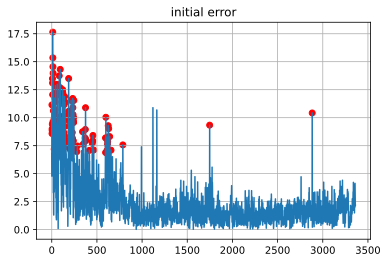

In [38]:
plt.plot(initial_error)
plt.title('initial error')
for index in too_large_error:
    plt.scatter(index, initial_error[index], c='r')
plt.grid(True)
plt.show()

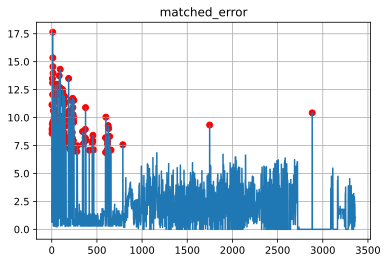

168


In [39]:
for index in too_large_error:
    matched_error[index] = initial_error[index]
plt.plot(matched_error)
plt.title('matched_error')
plt.grid(True)
for index in too_large_error:
    plt.scatter(index, initial_error[index], c='r')
plt.show()
print(len(too_large_error))

In [40]:
print('原始水平：')
print('中位数', np.quantile(initial_error, .50))
print('95分位数', np.quantile(initial_error, .95))

print('匹配后水平：')
print('中位数', np.quantile(matched_error, .50))
print('95分位数', np.quantile(matched_error, .95))

原始水平：
中位数 1.641920728278786
95分位数 6.989720842648051
匹配后水平：
中位数 1.3207859743380048
95分位数 6.747249271382429
